In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os

In [2]:
# =====================================================================
# Step 1: Define Paths (Update with your actual paths)
# =====================================================================
 # Replace with your folder path
base_dir = r'C:\Users\BAPS\Documents\Dicom Analaysis\Dicom_Analyzer\Classifier\Datasets\Kaggle_MRI_Dataset'
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')

# Verify paths exist
assert os.path.exists(train_dir), f"Directory {train_dir} not found!"
assert os.path.exists(test_dir), f"Directory {test_dir} not found!"

In [3]:
# =====================================================================
# Step 2: Load Binary Dataset (Tumor vs. No Tumor)
# =====================================================================
# Load training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',  # Binary labels (tumor=1, no_tumor=0)
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    color_mode='grayscale'  # Use 'rgb' if images are color
)

# Load testing data
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(224, 224),
    batch_size=32,
    shuffle=False,
    color_mode='grayscale'
)

# =====================================================================
# =====================================================================


Found 5712 files belonging to 2 classes.
Found 1311 files belonging to 2 classes.


In [4]:
# Step 3: Build Binary Classification Model
# =====================================================================
def build_model():
    model = models.Sequential([

        layers.Input(shape=(224, 224, 1)),  # 1 channel for grayscale
        # Preprocessing layers (resize + normalize)
        layers.Resizing(224, 224),  # Handles variable input sizes
        layers.Rescaling(1./255),   # Normalize pixels [0, 255] → [0, 1]
        
        # Feature extraction
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        
        # Classifier
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary output
    ])
    return model

model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,244,353 (84.86 MB)

 Trainable params: 22,244,353 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Step 4: Compile and Train
# =====================================================================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

# =====================================================================
class_weight = None  # Set based on your data distribution
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(
            filepath='brain_tumor_model.keras',  # <-- Added here
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ],
    class_weight=class_weight
)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7783 - loss: 0.4544 - precision: 0.8298 - recall: 0.8655
Epoch 1: val_loss improved from inf to 0.18842, saving model to brain_tumor_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.7789 - loss: 0.4534 - precision: 0.8302 - recall: 0.8659 - val_accuracy: 0.9283 - val_loss: 0.1884 - val_precision: 0.9614 - val_recall: 0.9338
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9553 - loss: 0.1208 - precision: 0.9675 - recall: 0.9704
Epoch 2: val_loss improved from 0.18842 to 0.15233, saving model to brain_tumor_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.9553 - loss: 0.1207 - precision: 0.9675 - recall: 0.9705 - val_accuracy: 0.9367 - val_loss: 0.1523 - val_precision: 0.9928 - val_recall: 0.9150
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9749 - loss: 0.0745 - precision: 0.9842 - recall: 0.9807
Epoch 3: val_loss improved from 0.15233 to 0.08394, sa

In [6]:
# Evaluate on test data
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")

# Confusion matrix
y_true = []
y_pred = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred.extend((model.predict(images) > 0.5).astype("int32"))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 371ms/step - accuracy: 0.9978 - loss: 0.0160 - precision: 0.7143 - recall: 0.7106
Test Accuracy: 1.00
Test Precision: 1.00
Test Recall: 0.99
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━

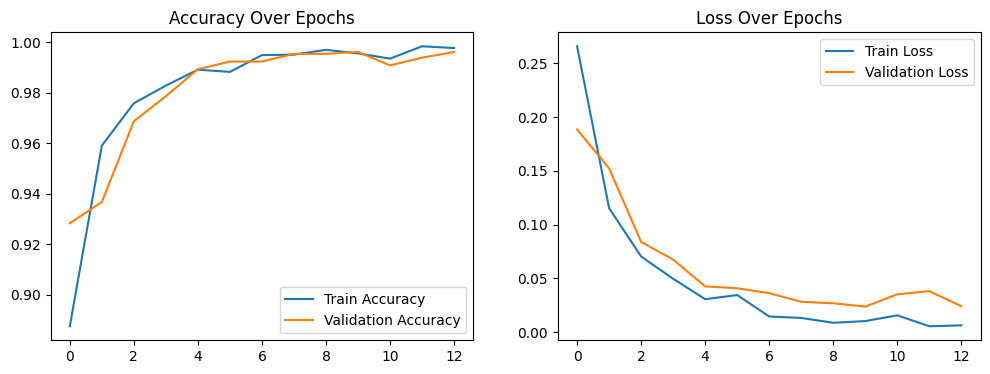

In [7]:
import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.show()

In [8]:
# Save entire model (including optimizer state)
model.save('final_brain_tumor_model.keras')

# Optional: Save training history
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [9]:
def predict_tumor(image_path):
    # Load image (match your model's expected format)
    img = tf.keras.utils.load_img(
        image_path,
        color_mode='grayscale',  # Must match your training data format
        target_size=(224, 224)   # Must match your model's input size
    )
    
    # Convert to array and preprocess
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Make prediction
    prediction = model.predict(img_array)[0][0]
    
    return "Tumor" if prediction > 0.5 else "No Tumor"

In [13]:
# Test your prediction function
test_image_path = "brain_tumor_img.jpg"
print(predict_tumor(test_image_path))

# Get probability scores
def get_tumor_probability(image_path):
    img = tf.keras.utils.load_img(image_path, color_mode='grayscale', target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return model.predict(img_array)[0][0]

print(f"Tumor probability: {get_tumor_probability(test_image_path):.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Tumor probability: 95.53%


In [14]:
test_image_path = "no_tumor_img.jpg"
print(f"Tumor probability: {get_tumor_probability(test_image_path):.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Tumor probability: 0.00%


In [24]:
import os
import re
import pydicom
import numpy as np
import tensorflow as tf
import shutil
from PIL import Image

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

dicom_folder = r"C:\Users\BAPS\Documents\Dicom Analaysis\Dicom_Dataset\ReMind_Datset\ReMIND\ReMIND-002"
output_folder = r"C:\Users\BAPS\Documents\Dicom Analaysis\Dicom_Analyzer\Image_Circle_of_Willis"

def dicom_to_images(dicom_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    dicom_files = [os.path.join(dicom_folder, f) for f in os.listdir(dicom_folder) if f.endswith('.dcm')]
    
    slices = []
    for dcm_file in dicom_files:
        ds = pydicom.dcmread(dcm_file)
        key = ds.SliceLocation if hasattr(ds, 'SliceLocation') else ds.InstanceNumber
        slices.append((key, dcm_file))
    
    slices.sort(key=lambda x: x[0])
    
    for i, (_, dcm_file) in enumerate(slices):
        ds = pydicom.dcmread(dcm_file)
        img_array = ds.pixel_array

        # Apply DICOM windowing
        if hasattr(ds, 'WindowCenter') and hasattr(ds, 'WindowWidth'):
            window_center = ds.WindowCenter
            window_width = ds.WindowWidth
            if isinstance(window_center, pydicom.multival.MultiValue):
                window_center = window_center[0]
                window_width = window_width[0]
            img_min = window_center - window_width // 2
            img_max = window_center + window_width // 2
            img_array = np.clip(img_array, img_min, img_max)
            img_array = (img_array - img_min) / (img_max - img_min) * 255
        else:
            img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min()) * 255

        img_array = img_array.astype('uint8')
        img_array = np.expand_dims(img_array, axis=-1)
        img = tf.keras.utils.array_to_img(img_array)
        img = img.resize((224, 224))
        img.save(os.path.join(output_folder, f'slice_{i+1:03d}.png'))

model = tf.keras.models.load_model("brain_tumor_model.keras")

def predict_tumor(image_path):
    img = tf.keras.utils.load_img(image_path, color_mode='grayscale', target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = img_array / 255.0  # Ensure model expects normalized input
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)[0][0]
    print(f"Prediction for {image_path}: {prediction}")  # Debugging
    
    return "Tumor" if prediction > 0.5 else "No Tumor"  # Adjust threshold as needed


def find_tumor_slices(dicom_folder, temp_image_folder="temp_dicom_images"):
    dicom_to_images(dicom_folder, temp_image_folder)
    image_files = sorted(os.listdir(temp_image_folder), key=natural_sort_key)
    tumor_slices = []
    
    for img_file in image_files:
        img_path = os.path.join(temp_image_folder, img_file)
        if predict_tumor(img_path) == "Tumor":
            slice_num = int(re.search(r'slice_(\d+).png', img_file).group(1))
            tumor_slices.append(slice_num)
    
    shutil.rmtree(temp_image_folder)  # Cleanup
    return tumor_slices

# Usage
tumor_slice_numbers = find_tumor_slices(dicom_folder)
print(f"Tumor found in slices: {tumor_slice_numbers}")

Tumor found in slices: []
